In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import log_loss

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt

In [2]:
class LogisticRegressionClassifier:
    def __init__(self, degree=2, max_iter=10000, tol=0.001):
        self.degree = degree
        self.max_iter = max_iter
        self.tol = tol
        self.weights = None
        self.classes = None
        self.cls_one_hot_encoding = None  # ground truth

    def predict(self, X):
        y_head = self._sigmoid(self.weights, X)
        prob = self._softmax(y_head.T)
        pred = np.argmax(prob, axis=1)  #Get Index (class) with highest score
        return pred

    def fit(self, X, y):
        # Train the model
        self.classes = np.sort(np.unique(y))  # ascending order
        self._init_weights(self.classes.shape[0], X.shape[1])  # Shape of (number of classes, number of features). Every class has his own weights vector
        self._create_label_matrix(y)

        # cls_one_hot_encoding (150,3) X.shape=(150,4)
        cost_list = []
        for _ in range(self.max_iter):
            y_head = self._sigmoid(self.weights, X)  # (3,150)
            prob = self._softmax(y_head.T)  # Row vector corresponds to the probability distribution for one sample (150,3)
            loss = self._log_loss(prob)

            self.weights = self.weights - self.tol * ((y_head - self.cls_one_hot_encoding.T) @ X) ### ??? Shapes... weights = (3,4) - (matrix with 3,4)
            cost_list.append(loss)
        return cost_list

    def _sigmoid(self, w, X):
        Z = np.float64(w @ X.T)
        y_head = 1 / (1 + np.exp(-Z))
        return y_head
    
    # https://stackoverflow.com/questions/34968722/how-to-implement-the-softmax-function-in-python
    def _softmax(self, y_head):
        assert len(y_head.shape) == 2
        s = np.max(y_head, axis=1)
        s = s[:, np.newaxis] # necessary step to do broadcasting. Transform array into next dimension as column vector
        e_x = np.exp(y_head - s)
        div = np.sum(e_x, axis=1)
        div = div[:, np.newaxis]
        return e_x / div

    def _log_loss(self, prob):
        # label matrix 
        L = np.multiply(self.cls_one_hot_encoding, np.log(prob))
        log_loss = -(np.sum(L)) / len(self.cls_one_hot_encoding)
        return log_loss

    def _create_label_matrix(self, y):
        #print("Classes: ", self.classes)
        self.cls_one_hot_encoding = np.zeros((len(y), len(self.classes)))  # (150, 3)
        for i, label in enumerate(y):
            self.cls_one_hot_encoding[i][label] = 1

    def _init_weights(self, num_cls, num_feat):
        self.weights = abs(np.random.randn(num_cls, num_feat))
        #print("Init Weights: \n", self.weights)
        

In [3]:
#X, y = load_iris(return_X_y=True)
vegi_df = pd.read_csv("G:/Meine Ablage/KI_Projekt/Daten/vegis_traindata.csv")
vegi_df = vegi_df.drop(columns=["Unnamed: 0", "green pixels", "Image"])
vegi_df.head()

,Hight,Width,R,G,B,green onion pixels,ratio area,circularity,keypoints,mean keypoints,Label
0,174,111,121,98,76,0,0.747411,0.740759,39,12.664070,Kartoffel
1,97,65,109,84,50,0,0.785250,0.812063,18,7.130874,Kartoffel
2,139,124,144,118,84,0,0.826178,0.791622,36,5.622304,Kartoffel
3,90,61,108,80,44,0,0.782149,0.816098,14,10.524947,Kartoffel
4,73,50,110,83,46,0,0.764247,0.810826,11,6.394969,Kartoffel


In [4]:
vegi_encoded_df = vegi_df.copy()

vegi_encoded_df.loc[vegi_encoded_df['Label'] == 'Karotte', 'Label'] = 0
vegi_encoded_df.loc[vegi_encoded_df['Label'] == 'Kartoffel', 'Label'] = 1
vegi_encoded_df.loc[vegi_encoded_df['Label'] == 'Zwiebel', 'Label'] = 2
vegi_encoded_df.loc[vegi_encoded_df['Label'] == 'Karotte_Trieb', 'Label'] = 3
vegi_encoded_df.loc[vegi_encoded_df['Label'] == 'Kartoffel_Trieb', 'Label'] = 4
vegi_encoded_df.loc[vegi_encoded_df['Label'] == 'Zwiebel_Trieb', 'Label'] = 5

vegi_encoded_df['Label'] = vegi_encoded_df['Label'].astype('int')
print(vegi_encoded_df['Label'].value_counts())

X = vegi_encoded_df.iloc[:, 0:10]
y = vegi_encoded_df.iloc[:, 10:11]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Image names are only for assignment from datapoint to corresponding image
#image_names = y_train.iloc[:,1]  
#image_names_test = y_test.iloc[:,1]

#y_train_clean = y_train.drop(columns="Image")
#y_test_clean = y_test.drop(columns="Image")

print(X_train.shape)
print(X_test.shape)

# Scaler
X_train_copy = X_train.copy()

col_names = ['Hight', 'Width', 'R', 'G', 'B', 'green onion pixels', 'ratio area', 'circularity', 'keypoints', 'mean keypoints']
features = X_train_copy[col_names]

ct = ColumnTransformer([
        ('standard1', StandardScaler(), ['Hight', 'Width', 'R', 'G', 'B', 'green onion pixels'])
    ], remainder='passthrough')

X_train_scaled = ct.fit_transform(features)

# Scale Testdata
col_names = ['Hight', 'Width', 'R', 'G', 'B', 'green onion pixels', 'ratio area', 'circularity', 'keypoints', 'mean keypoints']
features_test = X_test[col_names]
X_test_scaled = ct.transform(features_test)

Label
1    496
2    445
0    401
3    357
4    245
5    193
Name: count, dtype: int64
(1602, 10)
(535, 10)


In [90]:
"""
print(X_train.head())
print(X_test.head())
print(y_train_clean.head())
print(y_test_clean.head())
print(image_names.head())
"""

'\nprint(X_train.head())\nprint(X_test.head())\nprint(y_train_clean.head())\nprint(y_test_clean.head())\nprint(image_names.head())\n'

In [5]:
clf = LogisticRegressionClassifier(max_iter=30000, tol=0.001)
X_train_scaled_transformed = PolynomialFeatures(degree=2).fit_transform(X_train_scaled)
y_train = y_train.to_numpy()


In [6]:
loss_list = clf.fit(X_train_scaled_transformed, y_train)


C:\Users\Leon\AppData\Local\Temp\ipykernel_2944\2345023760.py:35: RuntimeWarning: overflow encountered in exp
  y_head = 1 / (1 + np.exp(-Z))


In [7]:
loss_list

[1.7901680798227888,
 1.7917594692280552,
 1.8581573442766937,
 1.8483178772587756,
 1.8246174747831339,
 1.7743270674542175,
 1.8403830947919304,
 1.8356854341643343,
 1.823052747206389,
 1.7673325699718576,
 1.8447828585900123,
 1.8072160796594607,
 1.8278977558895215,
 1.7979157501835268,
 1.8274199168811072,
 1.8239978511079558,
 1.813378746288346,
 1.754564135580892,
 1.8206385967706888,
 1.824161071802613,
 1.8340537240147983,
 1.772984866783262,
 1.82509311369907,
 1.836703334004472,
 1.8138240976957711,
 1.7925015436493008,
 1.772342239843181,
 1.8301133408097043,
 1.8260658159128025,
 1.8052036309382873,
 1.7844897225601186,
 1.8871381338291335,
 1.931929240496822,
 1.8103195298452683,
 1.6956805158224295,
 1.7945591639387397,
 1.8204847825198822,
 1.8112625189226819,
 1.778296542221067,
 1.7678191244425139,
 1.8392654121538887,
 1.8822102236995544,
 1.7608522195895908,
 1.645501880267521,
 1.7096481513039536,
 1.755116269671316,
 1.7745136136338093,
 1.7599319770191442,
 1.70

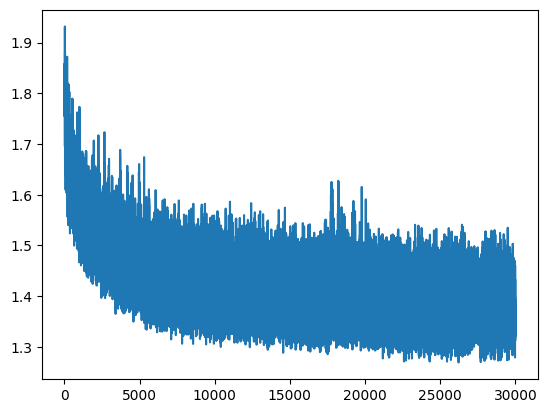

In [8]:
x_ = [i for i in range(len(loss_list))]
plt.plot(x_, loss_list)
plt.show()

In [9]:
y_train_pred = clf.predict(X_train_scaled_transformed)
X_test_scaled_transformed = PolynomialFeatures(degree=2).fit_transform(X_test_scaled)
y_test_pred = clf.predict(X_test_scaled_transformed)

accuracy_testdata = accuracy_score(y_test, y_test_pred)
accuracy_traindata = accuracy_score(y_train, y_train_pred)
print(f"Accuracy Test on Validation Data: {accuracy_testdata}\nAccuracy Train: {accuracy_traindata}")

number_correct_testdata = accuracy_score(y_test, y_test_pred, normalize=False)
number_correct_traindata = accuracy_score(y_train, y_train_pred, normalize=False)
print(f"Number Correct Predicions Test on Validation Data: {number_correct_testdata}\nNumber Correct Predicions Train: {number_correct_traindata}")

Accuracy Test on Validation Data: 0.697196261682243
Accuracy Train: 0.7091136079900124
Number Correct Predicions Test on Validation Data: 373
Number Correct Predicions Train: 1136


C:\Users\Leon\AppData\Local\Temp\ipykernel_2944\2345023760.py:35: RuntimeWarning: overflow encountered in exp
  y_head = 1 / (1 + np.exp(-Z))
C:\Users\Leon\AppData\Local\Temp\ipykernel_2944\2345023760.py:35: RuntimeWarning: overflow encountered in exp
  y_head = 1 / (1 + np.exp(-Z))


Vegis
[[194  34  15   8   4  12]
 [ 10 294   0   0   0   2]
 [ 18 131  97   0  12   2]
 [ 41  25   0 329   0   8]
 [  1 178   0   0  12   0]
 [ 70  10   2  19  20  81]]


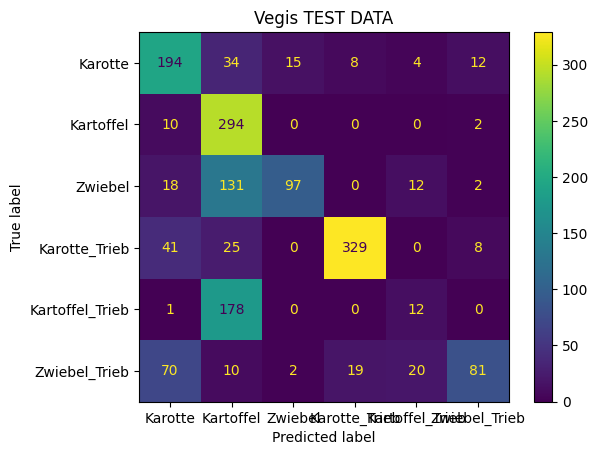

In [94]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test_clean,
    y_test_pred,
    display_labels=['Karotte', 'Kartoffel', 'Zwiebel', 'Karotte_Trieb', 'Kartoffel_Trieb', 'Zwiebel_Trieb'],
    cmap='viridis',
    normalize=None,
)
disp.ax_.set_title("Vegis TEST DATA")

print("Vegis")
print(disp.confusion_matrix)

Vegis
[[ 563  126   27   22    7   44]
 [  23  889    0    0    0    3]
 [  61  383  247    0   48    4]
 [ 114   73    0 1027    0   15]
 [   0  605    0    0   26    0]
 [ 187   38   11   53   53  236]]


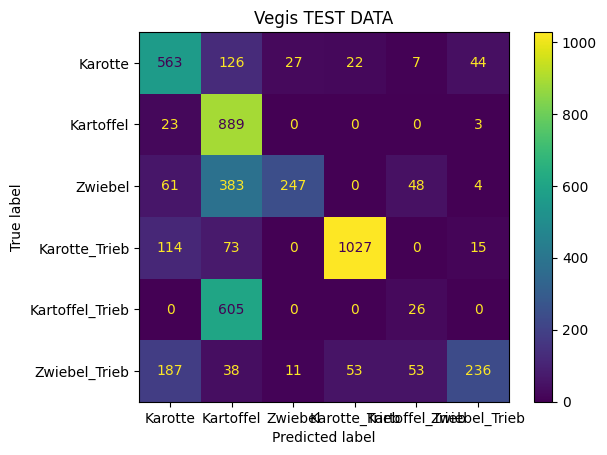

In [95]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_train_clean,
    y_train_pred,
    display_labels=['Karotte', 'Kartoffel', 'Zwiebel', 'Karotte_Trieb', 'Kartoffel_Trieb', 'Zwiebel_Trieb'],
    cmap='viridis',
    normalize=None,
)
disp.ax_.set_title("Vegis TEST DATA")

print("Vegis")
print(disp.confusion_matrix)

In [36]:
# Testdata
vegi_df_test = pd.read_csv("G:/Meine Ablage/KI_Projekt/Daten/TESTDATA_vegis_testdata.csv")
vegi_df_test = vegi_df_test.drop(columns=["Unnamed: 0", "green pixels", "Image"])
vegi_df_test.head()

vegi_encoded_df = vegi_df_test.copy()

vegi_encoded_df.loc[vegi_encoded_df['Label'] == 'Karotte', 'Label'] = 0
vegi_encoded_df.loc[vegi_encoded_df['Label'] == 'Kartoffel', 'Label'] = 1
vegi_encoded_df.loc[vegi_encoded_df['Label'] == 'Zwiebel', 'Label'] = 2
vegi_encoded_df.loc[vegi_encoded_df['Label'] == 'Karotte_Trieb', 'Label'] = 3
vegi_encoded_df.loc[vegi_encoded_df['Label'] == 'Kartoffel_Trieb', 'Label'] = 4
vegi_encoded_df.loc[vegi_encoded_df['Label'] == 'Zwiebel_Trieb', 'Label'] = 5

In [37]:
X_test_v, y_test_v = vegi_encoded_df.iloc[:,0:10], vegi_encoded_df.iloc[:,10]

In [38]:
X_test_v_scaled = ct.transform(X_test_v)
X_test__v_scaled_transformed = PolynomialFeatures(degree=2).fit_transform(X_test_v_scaled)


In [42]:
np.unique(y_test_v)

array([0, 1, 2, 3, 4, 5], dtype=object)

In [40]:
len(y_test_v_pred)

338

In [39]:
y_test_v_pred = clf.predict(X_test__v_scaled_transformed)
y_test_v_pred[0] = 4
print(y_test_v_pred)
accuracy_test = accuracy_score(y_test_v, y_test_v_pred)
print(f"Accuracy Test on Test Data: {accuracy_test}")

number_correct_test = accuracy_score(y_test_v, y_test_v_pred, normalize=False)
print(f"Number Correct Predicions Test on Test Data: {number_correct_test}")

[4 5 1 1 5 5 5 5 5 5 1 1 5 5 1 5 5 0 0 1 5 0 1 1 5 5 5 0 1 1 1 1 1 1 1 1 1
 0 1 1 0 1 0 5 5 1 1 1 1 1 1 1 1 1 2 1 1 2 0 1 1 5 1 1 1 2 1 5 1 0 1 1 2 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 5 0 0 2 2 2 5 2 2 2 2 2 2
 2 2 1 1 1 1 1 1 1 1 2 2 1 1 1 2 1 2 1 2 1 2 0 2 2 1 1 2 1 1 1 1 1 1 2 2 2
 2 2 2 2 1 1 1 2 1 2 2 1 1 2 2 2 3 3 3 3 3 2 3 3 5 3 2 2 5 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 3 3 3 3 3 3 3 3 3 3 3 5 5 5 2 2 5
 5 5 0 5 5 3 2 2 5 3 5 5 0 2 1 1 1 1 1 1 2 2 1 2 2 2 2 5 2 2 2 0 2 2 2 1 1
 0 5 1 0 5]


C:\Users\Leon\AppData\Local\Temp\ipykernel_2944\2345023760.py:35: RuntimeWarning: overflow encountered in exp
  y_head = 1 / (1 + np.exp(-Z))


ValueError: Classification metrics can't handle a mix of unknown and multiclass targets

In [34]:
y_test_v_pred[0]

0

In [14]:
#Debugging
def softmax(z):
    assert len(z.shape) == 2
    s = np.max(z, axis=1)
    #print("s max: ", s)
    s = s[:, np.newaxis] # necessary step to do broadcasting. Transform array into next dimension as column vector
    #print("s new: ", s)
    e_x = np.exp(z - s)
    #print("e_x", e_x)
    div = np.sum(e_x, axis=1)
    #print("div sum", div)
    div = div[:, np.newaxis] # dito
    #print("div", div)
    return e_x / div

def sigmoid(w, X):
    Z = w @ X.T
    y_head = 1 / (1 + np.exp(-Z))
    return y_head

weights = abs(np.random.randn(3, 4))
y_head = sigmoid(weights, X)
print(y_head.shape)
prob = softmax(y_head.T)
prob.shape


[[0.00626879 0.01704033 0.04632042 0.93037047]
 [0.01203764 0.08894682 0.24178252 0.65723302]
 [0.00626879 0.01704033 0.04632042 0.93037047]
 [0.         0.         1.         0.        ]]
Summe:  1.0


In [21]:
ass = vegi_encoded_df.copy()
ass.iloc[:,0:10].values

array([[174.        ,  76.        , 101.        , ...,   0.64145961,
         24.        ,   8.03071236],
       [165.        ,  94.        , 120.        , ...,   0.74021874,
         43.        ,   6.67579058],
       [177.        ,  99.        , 107.        , ...,   0.71515032,
         40.        ,   4.41407526],
       ...,
       [110.        ,  74.        , 119.        , ...,   0.53201209,
         62.        ,   4.80278999],
       [135.        ,  93.        , 106.        , ...,   0.42264254,
         89.        ,   4.78182369],
       [159.        ,  89.        , 105.        , ...,   0.34896301,
         61.        ,   5.62617245]])